In [3]:
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
from lattice_hamiltonians import *
from openfermion_hamiltonians import *
from sympy import S, symbols, printing

from compilers import * 
from utils import *

from plotting import crossover_advantage

Numpy 1.16 has memory leak bug  https://github.com/numpy/numpy/issues/13808
It is recommended to downgrade to numpy 1.15 or older


In [4]:
heisen = (heisenberg_hamiltonian(7, b_field=5, rng_seed=1, b_rand=False))
#heisen = exp_loc_graph_hamiltonian(7, 1, 1)

sim = CompositeSim(heisen, nb=1, inner_order=1, state_rand=True, exact_qd=True, use_density_matrices=True, imag_time=False)
partition_sim(sim, "trotter")

tstart = 0.005
tfinal = 2.5
tsteps = 300
times = np.geomspace(tstart, tfinal, tsteps)

#print(multi_infidelity_sample(sim, 1, exact_time_evolution_density(sim.unparsed_hamiltonian, 1, sim.initial_state), 40, 20))
epsilon_data=[]
for t in times:
    #density matrices
    epsilon_data.append(sim_trace_distance(sim, time=t, iterations=6, nb=1))
    #epsilon_data.append(infidelity(sim.simulate(t, iterations=15), exact_imaginary_channel(poli, t, sim.initial_state)))

    #imaginary time class
    #epsilon_data.append(i_sim.trace_dist(t, samples=1))

    #for vectors
    #exact_state = linalg.expm(-1 * sum(poli) * t) @ sim.initial_state
    #epsilon_data.append(infidelity(sim.simulate(t, iterations=1), exact_state / np.linalg.norm(exact_state, ord=2)))
#print(epsilon_data)
print('the trace is:')
print(np.trace(sim.final_state))


NameError: name 'heisenberg_hamiltonian' is not defined

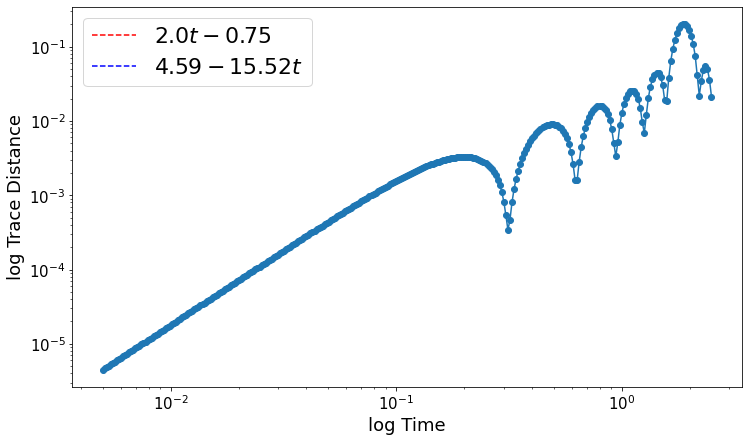

In [ ]:
data = np.log10(epsilon_data)
log_times = np.log10(times)
plt.figure(figsize = (12, 7))
plt.loglog(times, epsilon_data, 'o-') 
plt.xlabel('log Time', size = 18)
plt.ylabel('log Trace Distance', size = 18)
plt.xticks(fontsize=15, rotation=0)
plt.yticks(fontsize=15)

start_fit_points= 1 #declare the starting point to fit in the data
end_fit_points = 5

p = np.polyfit(log_times[start_fit_points: end_fit_points], data[start_fit_points: end_fit_points], 1)
f = np.poly1d(p)

t_new = np.linspace(log_times[start_fit_points], log_times[end_fit_points], 50)
y_new = f(t_new)

data = symbols("t")
poly = sum(S("{:6.2f}".format(v))*data**i for i, v in enumerate(p[::-1]))
eq_latex = printing.latex(poly)
plt.plot(t_new, y_new, 'r--', label="${}$".format(eq_latex))
plt.legend(fontsize= 22)

data = np.log10(epsilon_data)
start_fit_points1= -3 #declare the starting point to fit in the data
end_fit_points1 = -1
p1 = np.polyfit(log_times[start_fit_points1: end_fit_points1], data[start_fit_points1: end_fit_points1], 1)
f1 = np.poly1d(p1)

t_new1 = np.linspace(log_times[start_fit_points1], log_times[end_fit_points1], 50)
y_new1 = f1(t_new1)

data = symbols("t")
poly1 = sum(S("{:6.2f}".format(v))*data**i for i, v in enumerate(p1[::-1]))
eq_latex1 = printing.latex(poly1)

plt.plot(t_new1, y_new1, 'b--', label="${}$".format(eq_latex1))
plt.legend(fontsize= 22)
plt.show()

### Cost Analysis

In [ ]:
heisenberg = heisenberg_hamiltonian(length = 8, b_field = 5, rng_seed=1, b_rand=False)
print(heisenberg.shape)
normed_ham = normalize_hamiltonian(heisenberg)
print(np.linalg.norm(np.sum(normed_ham, axis=0), ord=2))

#trotter = CompositeSim(normed_ham, inner_order=1, state_rand=True, use_density_matrices=True, exact_qd=True, imag_time=False) 
#qdrift = CompositeSim(normed_ham, inner_order=1, state_rand=True, use_density_matrices=True, exact_qd=True, imag_time=False) 
chop11 = CompositeSim(normed_ham, inner_order=1, state_rand=True, use_density_matrices=True, exact_qd=True, imag_time=False)
chop12 = CompositeSim(normed_ham, inner_order=1, outer_order=1, state_rand=True, use_density_matrices=True, exact_qd=True, imag_time=False)
chop21 = CompositeSim(normed_ham, inner_order=1, outer_order=1, state_rand=True, use_density_matrices=True, exact_qd=True, imag_time=False)
chop22 = CompositeSim(normed_ham, inner_order=1, outer_order=1, state_rand=True, use_density_matrices=True, exact_qd=True, imag_time=False)
chop14 = CompositeSim(normed_ham, inner_order=1, outer_order=1, state_rand=True, use_density_matrices=True, exact_qd=True, imag_time=False)

#partition_sim(trotter, 'trotter')
#partition_sim(qdrift, "qdrift")

partition_sim(chop11, "chop", chop_threshold = 0.75)
partition_sim(chop12, "chop", chop_threshold = 0.75)
partition_sim(chop21, "chop", chop_threshold = 0.75)
partition_sim(chop22, "chop", chop_threshold = 0.75)
partition_sim(chop14, "chop", chop_threshold = 0.75)
print(chop11.trotter_norms, chop11.qdrift_norms)
#print(len(chop.trotter_norms), len(chop.qdrift_norms))

t_i = 0.005
t_f= 2.5
t_steps = 15
time = np.geomspace(t_i, t_f, t_steps)
epsilon=0.0001

print(time[:-2])
#print(trace_distance(trotter.simulate(time = 1.02889928, iterations=4), 
    #exact_time_evolution_density(normed_ham, time=1.02889928, initial_rho=trotter.initial_state)))

(29, 256, 256)
8.09020516681884
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] [0.01079211674518371, 0.025482505060266083, 2.2876271728617186e-06, 0.00720025509707838, 0.003174191903893478, 0.0019376774330746695, 0.00412229268164161, 0.008479529636141498, 0.010109050834214971, 0.015479195497215147, 0.010866787412364902, 0.02311759419418845, 0.004574488150536607, 0.04209394582415611, 0.0005553924953684671, 0.022201606529932652, 0.010801820928888588, 0.016360146278060757, 0.0030254583916387123, 0.0044154644823346054, 0.03226335405680701]
[0.005      0.00779388 0.01214891 0.01893742 0.02951918 0.04601377
 0.07172514 0.1118034  0.1742764  0.27165778 0.4234535  0.66006893
 1.02889928]


In [ ]:
#CompSim_results = dict()
qdrift_results = dict()
trotter_results = dict()
chop11_results = dict()
chop12_results = dict()
chop21_results = dict()
chop22_results = dict()
chop14_results = dict()

#local_partition(local_trot, "trotter")
trot_terms = dict()
qd_terms = dict()
nb_vals = dict()

for t in time[:-2]:
    #optimal chop code
    #partition_sim(sim, "exact_optimal_chop", time = t, epsilon=epsilon)
    #chop_results[t] = int(sim.gate_count)
    #nb_vals[t] = sim.nb

    #std chop
    chop11_results[t] = int(exact_cost(chop11, time=t, nb=3, epsilon=epsilon))
    chop12_results[t] = int(exact_cost(chop12, time=t, nb=4, epsilon=epsilon))
    chop21_results[t] = int(exact_cost(chop21, time=t, nb=5, epsilon=epsilon))
    chop22_results[t] = int(exact_cost(chop22, time=t, nb=7, epsilon=epsilon))
    chop14_results[t] = int(exact_cost(chop14, time=t, nb=9, epsilon=epsilon))

    #trot_terms[t] = len(sim.trotter_norms)
    #qd_terms[t] = len(sim.qdrift_norms)
    print(t)
    #trotter_results[t] = int(exact_cost(trotter, time=t, nb=1, epsilon=epsilon))

[sim_channel_performance] Iterations too large, already below error threshold
[sim_channel_performance] Iterations too large, already below error threshold
[sim_channel_performance] Iterations too large, already below error threshold
[sim_channel_performance] Iterations too large, already below error threshold
[sim_channel_performance] Iterations too large, already below error threshold
0.005
[sim_channel_performance] Iterations too large, already below error threshold
[sim_channel_performance] Iterations too large, already below error threshold
[sim_channel_performance] Iterations too large, already below error threshold
[sim_channel_performance] Iterations too large, already below error threshold
[sim_channel_performance] Iterations too large, already below error threshold
0.00779387751027389
[sim_channel_performance] Iterations too large, already below error threshold
[sim_channel_performance] Iterations too large, already below error threshold
[sim_channel_performance] Iterations t

In [ ]:
qd_times = time[:10]
for t in qd_times:
    qd_terms[t] = int(exact_cost(qdrift, time=t, nb=1, epsilon=epsilon))

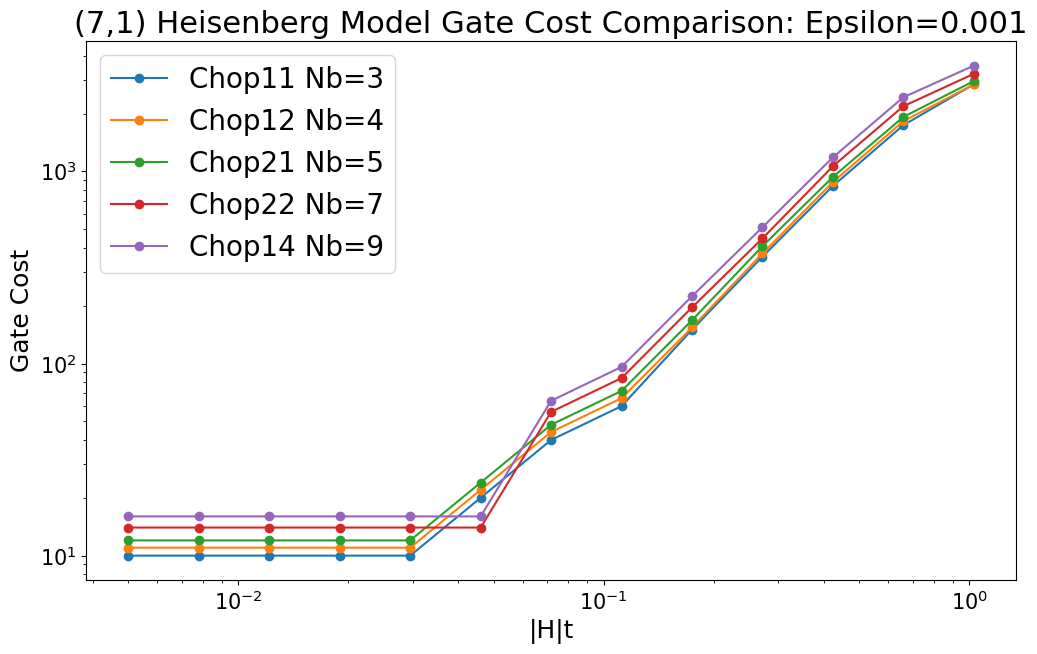

[]
13/04/2023_16:06


In [ ]:
#plotting
plt.figure(figsize = (12, 7))
plt.title("(7,1) Heisenberg Model Gate Cost Comparison: Epsilon=0.001", size =22)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("|H|t", size =18)
plt.ylabel("Gate Cost", size =18)
plt.loglog(time[:-2], list(chop11_results.values()), "o-", label="Chop11 Nb=3")
plt.loglog(time[:-2], list(chop12_results.values()), "o-", label="Chop12 Nb=4")
plt.loglog(time[:-2], list(chop21_results.values()), "o-", label="Chop21 Nb=5")
plt.loglog(time[:-2], list(chop22_results.values()), "o-", label="Chop22 Nb=7")
plt.loglog(time[:-2], list(chop14_results.values()), "o-", label="Chop14 Nb=9")
#plt.loglog(time, list(local_trot_results.values()), "o-", label="Local Trotter")
#plt.loglog(time[:-2], list(trotter_results.values()), "o-",label="Trotter")
#plt.loglog(qd_times, list(qd_terms.values()),"o-", label="QDrift")
plt.legend(fontsize = 20)
plt.show()

print(list(trotter_results.values()))

### Data Analysis

In [6]:
def extract(lst):
    x_lst = []
    y_lst = []
    z_lst = []
    for tup in lst:
        x, [y, z] = tup
        x_lst.append(x)
        y_lst.append(y)
        z_lst.append(z)
    return x_lst, y_lst, z_lst #gates. nb. weight

In [30]:
#Load file
filepath = os.path.join(os.path.expanduser('~'), 'Desktop', 'sim_runs', 'h2real12_12-05-2023_14:09')
# reads it back
with open(filepath,"r") as f:
  file = f.read()

# decoding the JSON to dictionay
dataset = json.loads(file)
print(dataset.keys())
#print(dataset['trotter2'])
#print(dataset['is_time_imaginary'])
#print(dataset)

dict_keys(['time', 'qdtime', 'norm', 'epsilon', 'compopt', 'compopt12', 'qdrift', 'trotter1', 'trotter2'])


0.5


KeyError: 'compopt21'

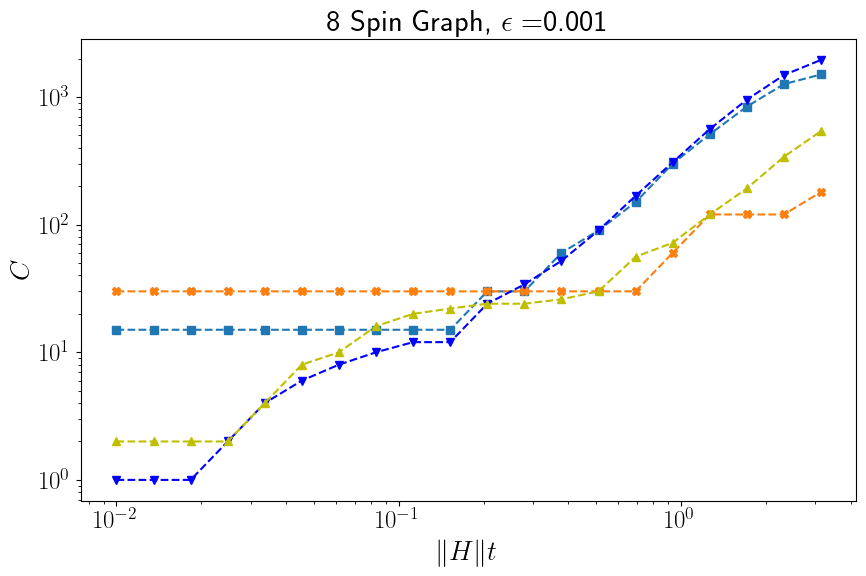

In [32]:
#plotting
plt.rcParams['text.usetex'] = True
time_series = np.array(dataset['time']) * dataset['norm']
savepath = os.path.join(os.path.expanduser('~'), 'Desktop', 'sim_runs', 'Plots', 'graph8.svg')
print(time_series[-1]/ (2*math.pi))

plt.figure(figsize = (10, 6))
plt.title(r"8 Spin Graph, $\epsilon =$" + str(dataset['epsilon']), size =22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(r"$\|H\| t$", size =20)
plt.ylabel(r"$C$", size =20)
plt.loglog(time_series, dataset['trotter1'], "s--", label=r"$\mathcal{T}^1$")
plt.loglog(time_series, dataset['trotter2'], "X--", label=r"$\mathcal{T}^2$")
#plt.loglog(time_series, dataset['compopt'], "bv--", label=r"$\tilde{\mathcal{X}}^1$")
plt.loglog(time_series, extract(dataset['compopt'])[0], "bv--", label=r"$\tilde{\mathcal{X}}^1$")
plt.loglog(time_series, extract(dataset['compopt12'])[0], "y^--", label=r"$\tilde{\mathcal{X}}^{1,2}$")
plt.loglog(time_series, extract(dataset['compopt21'])[0], "^--", label=r"$\tilde{\mathcal{X}}^{2,1}$")
plt.loglog(time_series, extract(dataset['compop22'])[0], "o--", label=r"$\tilde{\mathcal{X}}^{2,2}$")
#plt.loglog(time_series, dataset['compheur11_1'], "o--", label=r"$\mathcal{X}^1_{N_B = 1}$")
#plt.loglog(time_series, dataset['compheur11_5'], "p--", label=r"$\mathcal{X}^{1}_{N_B = 5}$")
#plt.loglog(time_series, dataset['compheur11_10'], "p--", label=r"$\mathcal{X}^{1}_{N_B = 10}$")
plt.loglog(time_series[:len(dataset['qdrift'])], dataset['qdrift'], "d--", label=r"$\mathcal{Q}$")
plt.legend(fontsize = 18)
#uncomment to save below
#plt.savefig(savepath, format="svg")
plt.show()

array('d', [64.0])
array('d', [16.25])
3.9384615384615387


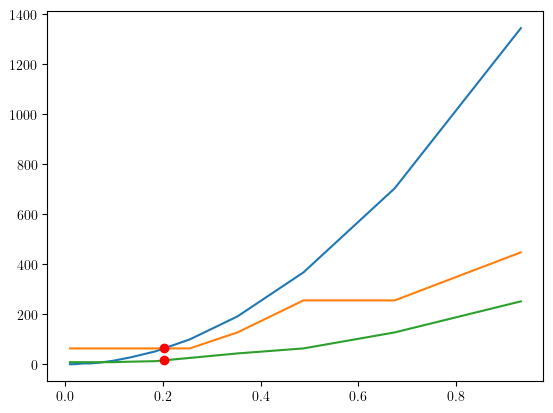

In [17]:
#crossover
#l = len(dataset['qdrift'])
l = len(dataset['qdtime'])
qdrift_data = dataset['qdrift'][:l]
trotter_data = dataset['trotter1'][:l] 
comp_data = extract(dataset['compopt'])[0][:l]
#comp_data = dataset['compopt'][:l]
adv = crossover_advantage(qd_data=qdrift_data, trot_data= trotter_data, comp_data= comp_data, times = time_series[:l])
print(adv)

In [25]:
#study the number of terms
def card_A(w_list, H_list): #returns a list of the fraction |A|/|H| where H is the set of all terms 
    a_card_t = []
    for weight in w_list:
        a_terms = 0
        for h in H_list:
            if np.linalg.norm(h, 2) >= weight:
                a_terms +=1
        a_card_t.append(a_terms)
    return (1/len(H_list)) * np.array(a_card_t)

#hamiltonian = hydrogen_chain_hamiltonian(3, 0.8)
hamiltonian = exp_loc_graph_hamiltonian(8, 1, 1)

comp_w = card_A(extract(dataset['compopt'])[2], hamiltonian)
comp22_w = card_A(extract(dataset['compop22'])[2], hamiltonian)


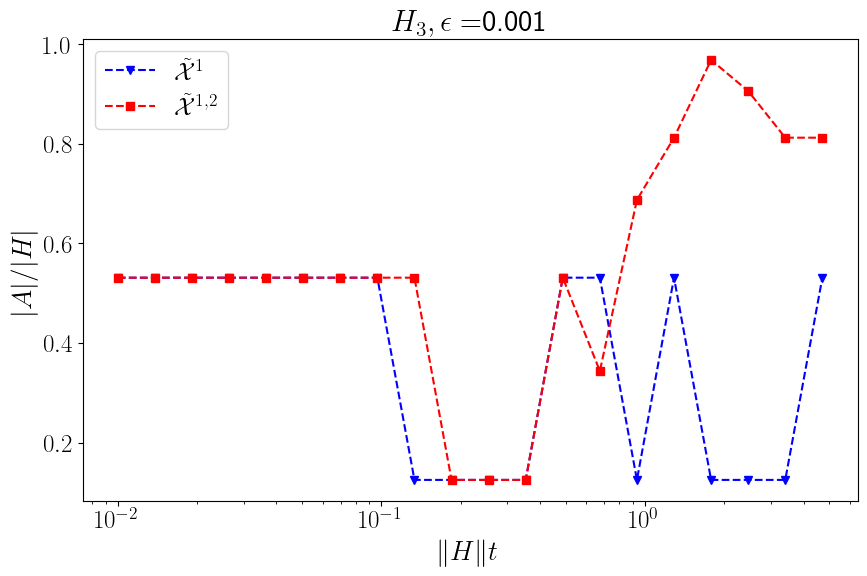

[0.53125 0.53125 0.53125 0.53125 0.53125 0.53125 0.53125 0.53125 0.125
 0.125   0.125   0.125   0.53125 0.53125 0.125   0.53125 0.125   0.125
 0.125   0.53125]
[0.53125 0.53125 0.53125 0.53125 0.53125 0.53125 0.53125 0.53125 0.53125
 0.125   0.125   0.125   0.53125 0.34375 0.6875  0.8125  0.96875 0.90625
 0.8125  0.8125 ]


In [26]:
plt.rcParams['text.usetex'] = True
time_series = np.array(dataset['time']) * dataset['norm']
savepath = os.path.join(os.path.expanduser('~'), 'Desktop', 'sim_runs', 'Plots', 'H3_w')

plt.figure(figsize = (10, 6))
plt.title(r"$ H_3, \epsilon =$" + str(dataset['epsilon']), size =22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(r"$\|H\| t$", size =20)
plt.ylabel(r"$|A|/|H|$", size =20, rotation=90)
plt.semilogx(time_series, comp_w, "bv--", label=r"$\tilde{\mathcal{X}}^1$")
plt.semilogx(time_series, comp22_w, "rs--", label=r"$\tilde{\mathcal{X}}^{1,2}$")
plt.legend(fontsize = 18)
#plt.savefig(savepath, format="svg")
plt.show()
print(comp_w)
print(comp22_w)

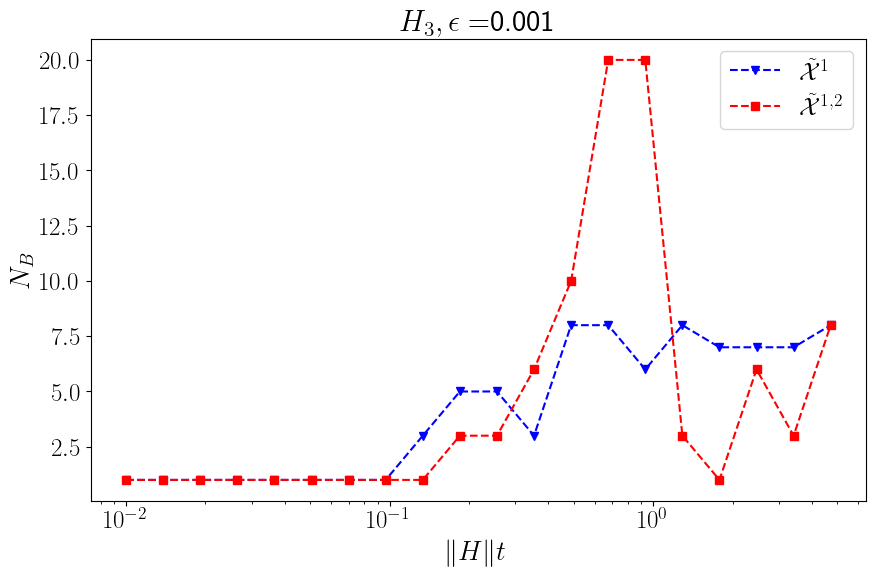

[1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 6, 10, 20, 20, 3, 1, 6, 3, 8]
[1, 1, 1, 1, 1, 1, 1, 1, 3, 5, 5, 3, 8, 8, 6, 8, 7, 7, 7, 8]


In [28]:
#study the choice of N_b

plt.rcParams['text.usetex'] = True
time_series = np.array(dataset['time']) * dataset['norm']
savepath = os.path.join(os.path.expanduser('~'), 'Desktop', 'sim_runs', 'Plots', 'H3_nb')

plt.figure(figsize = (10, 6))
plt.title(r"$H_3, \epsilon =$" + str(dataset['epsilon']), size =22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(r"$\|H\| t$", size =20)
plt.ylabel(r"$N_B$", size =20, rotation=90)
plt.semilogx(time_series, extract(dataset['compopt'])[1], "bv--", label=r"$\tilde{\mathcal{X}}^1$")
plt.semilogx(time_series, extract(dataset['compop22'])[1], "rs--", label=r"$\tilde{\mathcal{X}}^{1,2}$")
plt.legend(fontsize = 18)
#plt.savefig(savepath, format="svg")
plt.show()
print(extract(dataset['compop22'])[1])
print(extract(dataset['compopt'])[1])

### Local Blocks Study

In [10]:
#Load file
filepath = os.path.join(os.path.expanduser('~'), 'Desktop', 'sim_runs', 'local_heisenberg_920-06-2023_11:20')
# reads it back
with open(filepath,"r") as f:
  file = f.read()

# decoding the JSON to dictionay
dataset = json.loads(file)
print(dataset.keys())
#print(dataset['trotter2'])
#print(dataset['is_time_imaginary'])
#print(dataset)
print(dataset['ham_dims'])

dict_keys(['partitions', 'time', 'norm', 'epsilon', 'blocks', 'block_nb', 'ham_dims', 'coupling', 'optimal_chop_block_2', 'trotter_block_2', 'chop_block_2', 'optimal_chop_block_3', 'trotter_block_3', 'chop_block_3', 'optimal_chop_block_4', 'trotter_block_4', 'chop_block_4', 'trotter', 'qdrift'])
[33, 512, 512]


0.15915494309189535


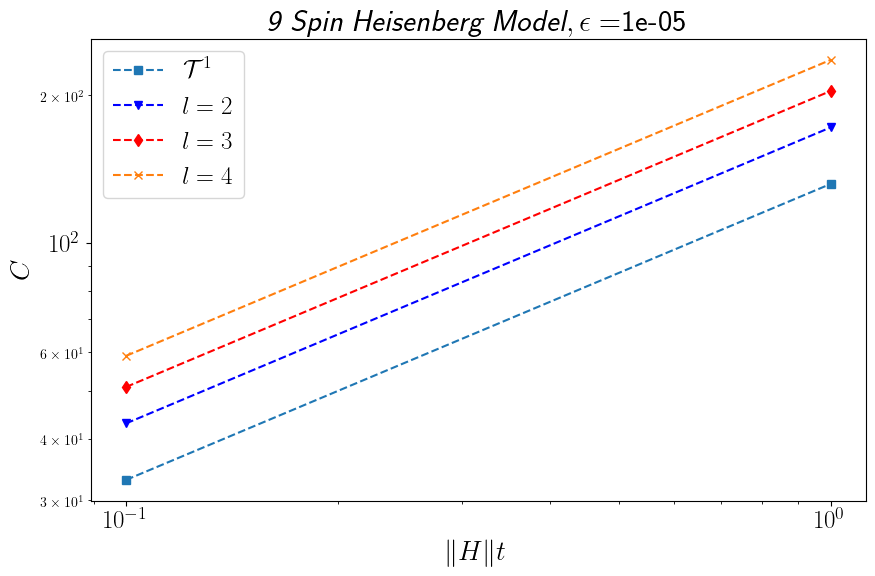

In [11]:
#block plotting
plt.rcParams['text.usetex'] = True
time_series = np.array(dataset['time']) * dataset['norm']
savepath = os.path.join(os.path.expanduser('~'), 'Desktop', 'sim_runs', 'Plots', 'H9_blockadv_cplg')
print(time_series[-1]/ (2*math.pi))

plt.figure(figsize = (10, 6))
plt.title(r"$\textit{9 Spin Heisenberg Model}, \epsilon =$" + str(dataset['epsilon']), size =22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(r"$\|H\| t$", size =20)
plt.ylabel(r"$C$", size =20)
plt.loglog(time_series, dataset['trotter'], "s--", label=r"$\mathcal{T}^1$")
#plt.loglog(time_series, dataset['block 2.0'], "X--", label=r"$\mathcal{T}^2$")
plt.loglog(time_series, dataset['trotter_block_2'], "bv--", label=r"$l = 2$")
plt.loglog(time_series, dataset['trotter_block_3'], "rd--", label=r"$l = 3$")
plt.loglog(time_series, dataset['trotter_block_4'], "x--", label=r"$l = 4$")
#plt.loglog(time_series, dataset['block 5'], "o--", label=r"$l = 5$")
plt.legend(fontsize = 18)
#plt.savefig(savepath, format="svg")
plt.show()

### Dynamics

In [2]:
dim = 6
#ising = normalize_hamiltonian(ising_model(dim=dim, b_field=1.5))
ising = ising_model(dim=dim, b_field=0.1)
cooler = CompositeSim(ising, inner_order=1, nb=1, state_rand=True, use_density_matrices=True, exact_qd=True, imag_time=True, rng_seed=1) 
partition_sim(cooler, "trotter")
print(cooler.initial_state)
 
beta = np.linspace(0.00001, 1.5, 100)
populations = []
energies = []
spins = []
amplitudes = np.zeros((2**dim, len(beta)))
x_measurements = []

for b in range(len(beta)):
    state_t = cooler.simulate(time=beta[b], iterations=100)
    if cooler.use_density_matrices == True:
        #populations.append(np.real(np.diag(state_t))
        energies.append(np.real(np.trace(sum(ising) @ state_t)))
        local_spin = []
        local_x = []
        for j in range(dim):
            local_spin.append(np.real(np.trace(state_t @ initialize_operator(Z, j, dim))))
            local_x.append(np.real(np.trace(state_t @ initialize_operator(X, j, dim))))
        spins.append(local_spin)
        x_measurements.append(local_x)
    else:
        energies.append(np.real((state_t.T.conj() @ sum(ising) @ state_t).flat[0]))
        amplitudes[:, b] =  np.real(np.abs(state_t.flat[0])**2)
amplitudes = np.transpose(amplitudes)

[[ 0.02692756+0.j         -0.00964571-0.00164814j -0.00285558-0.01961837j
  ...  0.02469851-0.01306447j  0.01523956-0.02239909j
  -0.00298631-0.00650151j]
 [-0.00964571+0.00164814j  0.00355606+0.j          0.00222366+0.00685271j
  ... -0.00804761+0.00619152j -0.00408799+0.00895632j
   0.00146766+0.00214612j]
 [-0.00285558+0.01961837j  0.00222366-0.00685271j  0.01459601+0.j
  ...  0.00689907+0.01937982j  0.014703  +0.0134783j
   0.00505344-0.00148625j]
 ...
 [ 0.02469851+0.01306447j -0.00804761-0.00619152j  0.00689907-0.01937982j
  ...  0.02899248+0.j          0.02484542-0.01315111j
   0.00041523-0.00741219j]
 [ 0.01523956+0.02239909j -0.00408799-0.00895632j  0.014703  -0.0134783j
  ...  0.02484542+0.01315111j  0.02725696+0.j
   0.00371804-0.00616361j]
 [-0.00298631+0.00650151j  0.00146766-0.00214612j  0.00505344+0.00148625j
  ...  0.00041523+0.00741219j  0.00371804+0.00616361j
   0.00190094+0.j        ]]


(array([-7., -6., -5., -4., -3., -2., -1.,  0.,  1.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

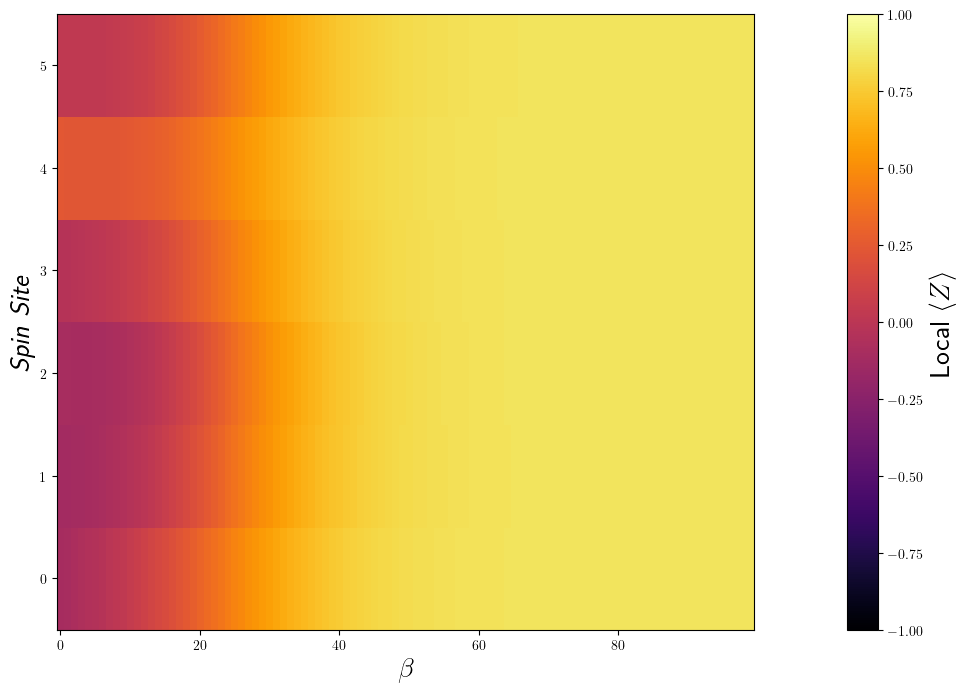

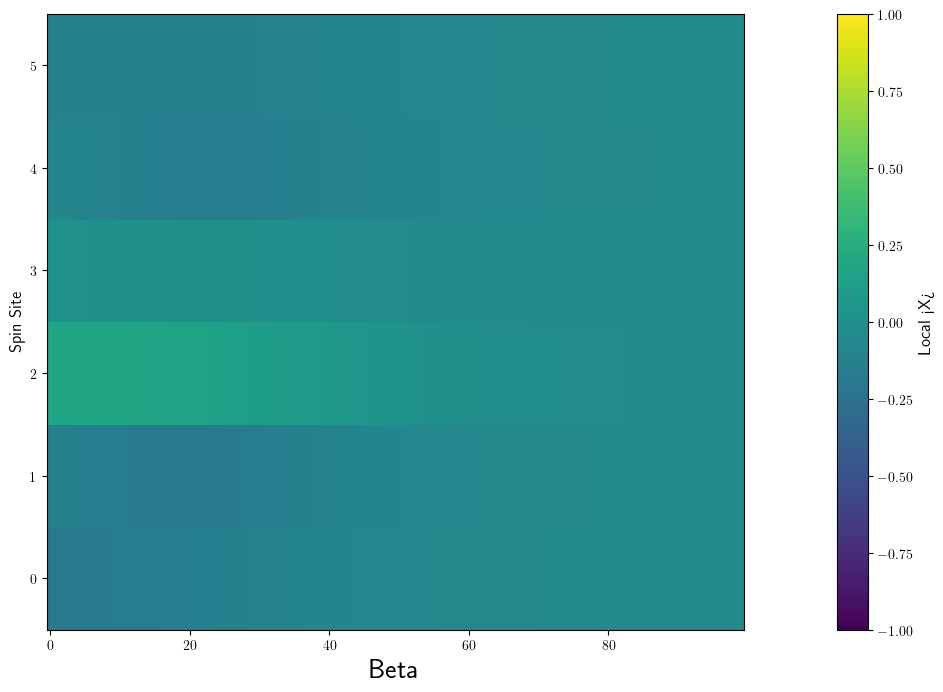

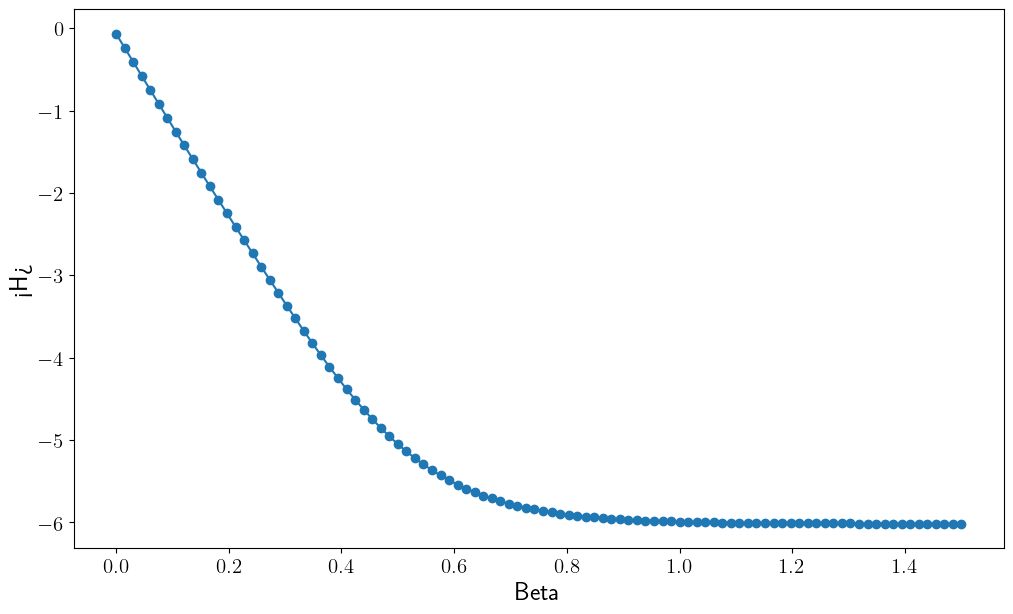

In [12]:
plt.rcParams['text.usetex'] = True
plt.figure(figsize = (12,8))
#plt.ylim(-60,60) #limits the range the plot shows
plt.xlabel(r'$\beta$', size = 20)
plt.ylabel(r'\textit{Spin Site}', size = 20)
plt.imshow(np.transpose(spins), origin = 'lower', aspect = 'auto', 
           cmap = 'inferno', vmax=1, vmin=-1, interpolation = 'none') 
# vmax alters the sensitivity of the colour plot, so increase for large particle numbers
cbar = plt.colorbar(pad = 0.1) #pad chooses the distance of the colour bar from the plot
cbar.set_label(r'Local $\langle Z \rangle$',size=20) 

plt.figure(figsize = (12,8))
#plt.ylim(-60,60) #limits the range the plot shows
plt.xlabel('Beta', size = 20)
plt.ylabel('Spin Site', size = 12)
plt.imshow(np.transpose(x_measurements), origin = 'lower', aspect = 'auto', 
             vmax=1, vmin=-1, interpolation = 'none') 
# vmax alters the sensitivity of the colour plot, so increase for large particle numbers
cbar = plt.colorbar(pad = 0.1) #pad chooses the distance of the colour bar from the plot
cbar.set_label('Local <X>',size=12)

plt.figure(figsize = (12, 7))
plt.plot(beta, energies, 'o-') 
plt.xlabel('Beta', size = 18)
plt.ylabel('<H>', size = 18)
plt.xticks(fontsize=15, rotation=0)
plt.yticks(fontsize=15)

In [ ]:
def mu(temp, vol):
    return (-8/27 * temp * np.log(3* vol -1) - 2/3 * 1/vol + temp * 8/27 * 1/(3*vol -1))

def pressure(temp, vol):
    return (8 * temp / (3*vol -1) - 3/ vol**2)  

def ionizing_frac(t, f_i):
    return (1/f_i * np.exp(-157971/ t) * 1/0.2436 * (8.457**26 / t)**(3/2))**(1/2)

In [ ]:
temp = 0.9
volumes = np.linspace(0.576, 4.909, 1000)
pressures = []
potential = []
for i in volumes:
    pressures.append(pressure(temp=temp, vol=i))
    potential.append(mu(temp=temp, vol=i))
#print(pressures)

temps = np.linspace(0, 6000, 1000)
frac = []
for j in temps:
    frac.append(ionizing_frac(j,10**(-9)))


/opt/anaconda3/envs/compsim/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  
/opt/anaconda3/envs/compsim/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


(array([-5.0e+13,  0.0e+00,  5.0e+13,  1.0e+14,  1.5e+14,  2.0e+14,
         2.5e+14]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

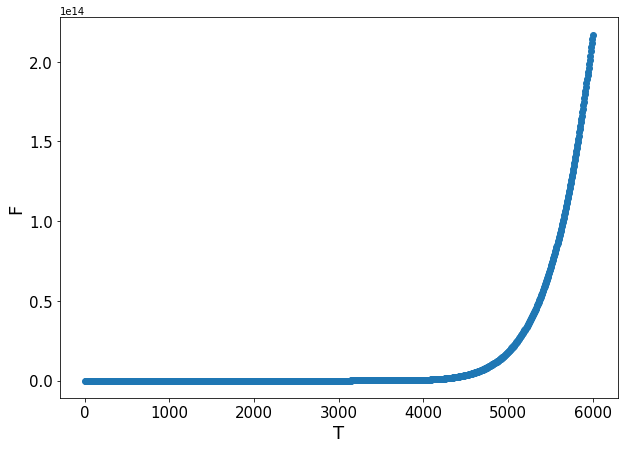

In [ ]:
plt.figure(figsize = (10, 7))
plt.plot(temps, frac, 'o-') 
plt.xlabel('T', size = 18)
plt.ylabel('F', size = 18)
plt.xticks(fontsize=15, rotation=0)
plt.yticks(fontsize=15)

(array([0., 1., 2., 3., 4., 5., 6.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

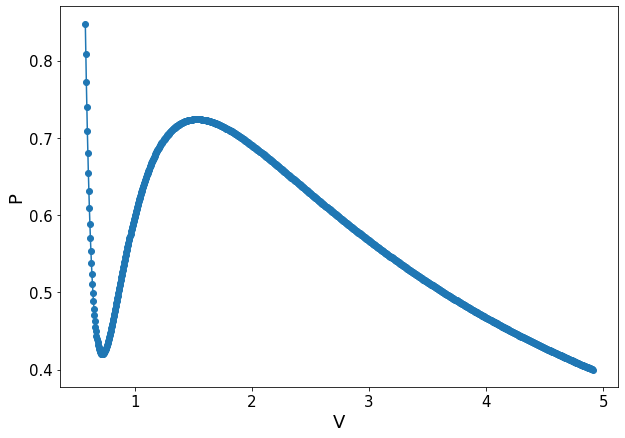

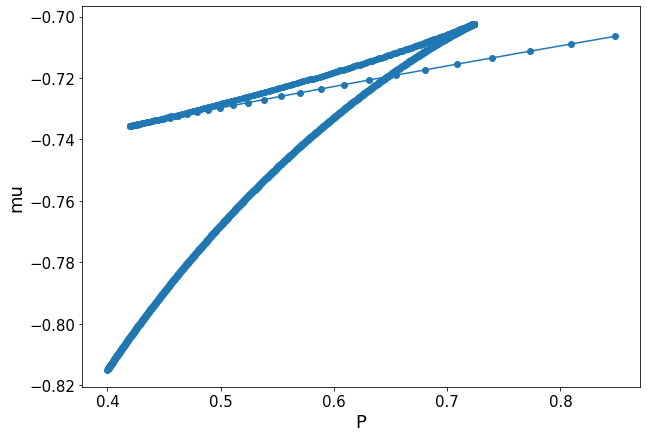

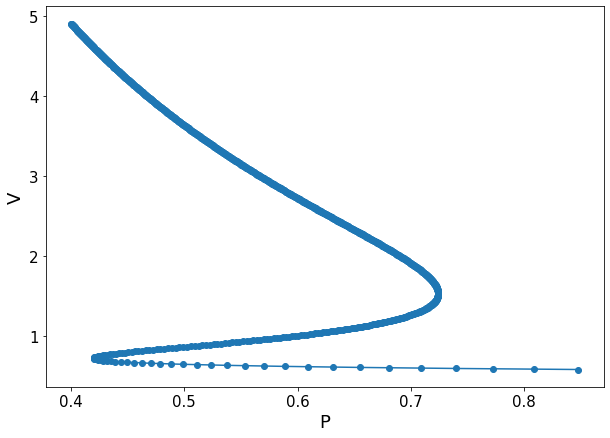

In [ ]:
plt.figure(figsize = (10, 7))
plt.plot(volumes, pressures, 'o-') 
plt.xlabel('V', size = 18)
plt.ylabel('P', size = 18)
plt.xticks(fontsize=15, rotation=0)
plt.yticks(fontsize=15)

plt.figure(figsize = (10, 7))
plt.plot(pressures, potential, 'o-') 
plt.xlabel('P', size = 18)
plt.ylabel('mu', size = 18)
plt.xticks(fontsize=15, rotation=0)
plt.yticks(fontsize=15)

plt.figure(figsize = (10, 7))
plt.plot(pressures, volumes, 'o-') 
plt.xlabel('P', size = 18)
plt.ylabel('V', size = 18)
plt.xticks(fontsize=15, rotation=0)
plt.yticks(fontsize=15)